# # Smart Voice Assistant For The Blind

In [1]:
#Importing the necessary modules
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [2]:
# Loading the VGG16
model = VGG16()

#Changing the model: Removing the predicted values from the existing VGG16 model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

553467096/553467096 [==============================] - 8s 0us/step


In [3]:
#!pip install tensorflow ipywidgets tqdm jupyter pillow

In [4]:
!pip install image
!pip install tdqm

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 55.5 MB/s eta 0:00:00
  Created wheel for image: filename=image-1.5.33-py2.py3-none-any.whl size=19483 sha256=8c5c546a2868122ecbe35f0486a8fde6c06da147e2ef3c0d3b1ba530d3b1250e
  Stored in directory: /root/.cache/pip/wheels/70/0c/a4/7cfa53a5c6225c2db2bfec08e782b43d0f25fdae2e995b69be
Successfully built image
  Preparing metadata (setup.py) ... done
  Created wheel for tdqm: filename=tdqm-0.0.1-py3-none-any.whl size=1323 sha256=216fa414da81d1a1583686622f54468eb26b22de1d102cb3854342a1cbf19903
  Stored in directory: /root/.cache/pip/wheels/37/31/b8/7b711038035720ba0df14376af06e5e76b9bd61759c861ad92
Successfully built tdqm


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os

#BASE_DIR = '../input/flickr8k'
BASE_DIR = '/content/drive/MyDrive/Flickr 8k Dataset'
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for i in tqdm(os.listdir(directory)):
    img_path = directory + '/' + i
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    image_id = i.split('.')[0]
    features[image_id] = feature

pickle.dump(features, open(os.path.join(BASE_DIR, 'features.pkl'), 'wb'))

  0%|          | 0/8091 [00:00<?, ?it/s]

In [7]:
# load features from the saved pickle file
with open(os.path.join('/content/drive/MyDrive/Flickr 8k Dataset', 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [8]:
# Reading the descriptions.txt file
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    desc_doc = f.read()

In [9]:
#Mapping the descriptions to the images
mapping = {}
for each_desc in tqdm(desc_doc.split('\n')):
    tokens = each_desc.split(',')
    if len(each_desc) < 2:
        continue
    image_id, desc_of = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    desc_of = " ".join(desc_of)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(desc_of)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [10]:
# Editing the descriptions: Convert to lower case and add beginning and ending
def edit_description(mapping):
    for key, desc in mapping.items():
        for i in range(len(desc)):
            x = desc[i]
            x = x.lower()
            x = x.replace('[^A-Za-z]', '')
            x = x.replace('\s+', ' ')
            x = 'beginning ' + " ".join([word for word in x.split() if len(word)>1]) + ' ending'
            desc[i] = x

In [11]:
# Calling the preprocessing text function
edit_description(mapping)

In [12]:
# Appending all descriptions into a list: Each image with 5 descriptions
img_desc = []
for key in mapping:
    for caption in mapping[key]:
        img_desc.append(caption)

In [13]:
# Tokenizing the text: finding the unique words from all the captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(img_desc)
vocab_size = len(tokenizer.word_index) + 1

In [14]:
print("Unique words in the captions are: " + str(vocab_size))

Unique words in the captions are: 8484


In [15]:
# Get the maximum description length for the padding required
max_length = max(len(text.split()) for text in img_desc)
max_length

35

In [16]:
# Splitting the dataset into Training and Testing: 90% is given to training and remaining is for the test
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [17]:
# Generating the data frm the inputs of images and descriptions and passing it for the model
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            text = mapping[key]
            for t in text:
                seq = tokenizer.texts_to_sequences([t])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [18]:
# Giving the inputs for the CNN

inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
output = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [19]:
#Training the model with 20 epochs
epochs = 5
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

model.save('best_model.h5')

227/227 [==============================] - 1221s 5s/step - loss: 2.1956


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
def mapping_toword(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [21]:
def predict_description(model, image, tokenizer, max_length):
    in_text = 'beginning'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        desc_predict = model.predict([image, sequence], verbose=0)

        desc_predict = np.argmax(desc_predict)
        word = mapping_toword(desc_predict, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'ending':
            break

    return in_text

In [22]:
actual, predicted = list(), list()

for key in tqdm(test):
    desc = mapping[key]
    y_pred = predict_description(model, features[key], tokenizer, max_length)
    actual_desc = [caption.split() for text in desc]
    y_pred = y_pred.split()
    actual.append(actual_desc)
    predicted.append(y_pred)

  0%|          | 0/810 [00:00<?, ?it/s]

In [23]:
!pip install pyttsx3

In [24]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_text(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    desc = mapping[image_id]
    y_pred = predict_description(model, features[image_id], tokenizer, max_length)
    plt.imshow(image)

    return str(y_pred)

In [25]:
# Installing the required modules

!pip3 install gTTS pyttsx3 playsound pygobject

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.9/346.9 kB 12.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for playsound: filename=playsound-1.3.0-py3-none-any.whl size=7020 sha256=1edafff3b85a438538c1a5ef139b81dc83f83bc411c3afa3e7afbfd0a4381e31
  Stored in directory: /root/.cache/pip/wheels/90/89/ed/2d643f4226fc8c7c9156fc28abd8051e2d2c0de37ae51ac45c
  error: subprocess-exited-with-error
  
  × Building wheel for pycairo (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pycairo
Successfully built playsound
Failed to build pycairo
ERROR: Could not build wheels for pycairo, which is required to install pyproject.toml-based projects


In [26]:
pip install SpeechRecognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 20.6 MB/s eta 0:00:00


In [27]:
# Setting up the engine for voice to text for input commands
import os
import speech_recognition as sr
import pyttsx3


def voice_output(command):
    engine = pyttsx3.init()
    engine.say(command)
    engine.runAndWait()
r = sr.Recognizer()
x = 0



In [28]:
!pip install gTTs

  Using cached gTTS-2.5.1-py3-none-any.whl (29 kB)


beginning two dogs play in the grass ending


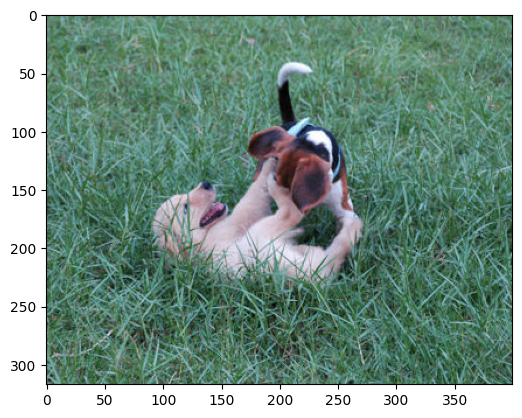

In [29]:
from gtts import gTTS
from IPython.display import Audio

text = str(generate_text("23445819_3a458716c1.jpg"))
print(text)

res = text.split(' ', 1)[1]
text = res.rsplit(' ', 1)[0]

tts = gTTS(text)

tts.save('info.wav')
sound_file = 'info.wav'
Audio(sound_file, autoplay=True)

beginning two dogs play with each other on the street ending


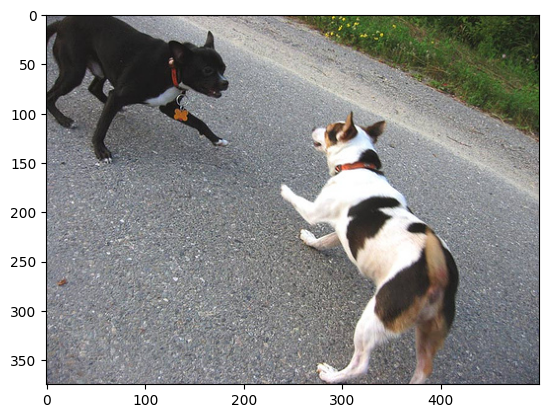

In [30]:
text = str(generate_text("1001773457_577c3a7d70.jpg"))
print(text)

res = text.split(' ', 1)[1]
text = res.rsplit(' ', 1)[0]

tts = gTTS(text)

tts.save('info.wav')
sound_file = 'info.wav'
Audio(sound_file, autoplay=True)

beginning two little boys are sitting in front of painted painted painting ending


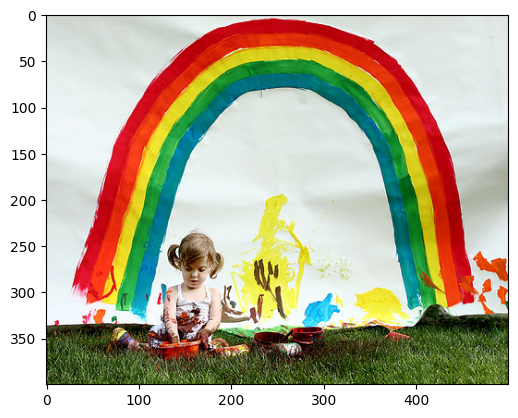

In [31]:
text = str(generate_text("1002674143_1b742ab4b8.jpg"))
print(text)

res = text.split(' ', 1)[1]
text = res.rsplit(' ', 1)[0]

tts = gTTS(text)

tts.save('info.wav')
sound_file = 'info.wav'
Audio(sound_file, autoplay=True)